In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.linalg import sqrtm

### Importing Data & Structure

In [82]:
directory = 'experiment_small/'
file_name = directory + 'network_params/network.txt'
with open(file_name, 'r') as file:
    elist = [eval(line.strip()) for line in file]

G = nx.Graph()
G.add_weighted_edges_from(elist)
network = np.array(list(G.nodes))
N = len(network)
nx.write_graphml(G, directory + "network_params/graph.graphml")

df = pd.read_csv('data_synth.csv')
df = df.drop(columns=['times'])
data = df.to_numpy()
T = len(data)
times = np.arange(T)

supply = []
demand = []
supply_init = np.array(data[:,0])
demand_init = np.array(data[:,1])
segment_size = 365
populations = np.loadtxt(directory + 'network_params/node_weights.txt', delimiter=',',dtype=float)/177924
max_population = np.max(populations)

for n in range(N):
    rand = np.random.randint(0, 2)
    if rand==0:
        supply.append((populations[n]*supply_init))
        demand.append(populations[n]*demand_init)
    else:
        supply.append((populations[n]*demand_init))
        demand.append(populations[n]*supply_init)

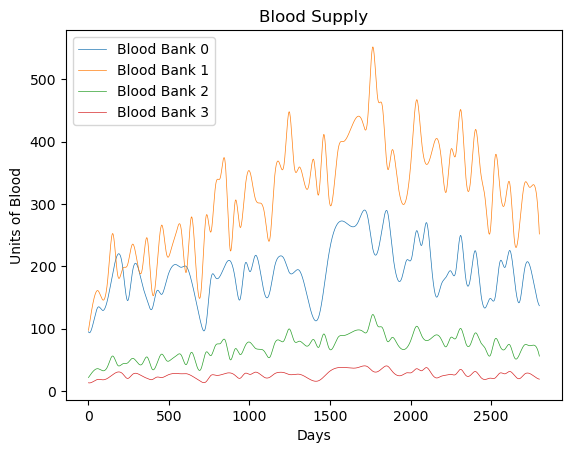

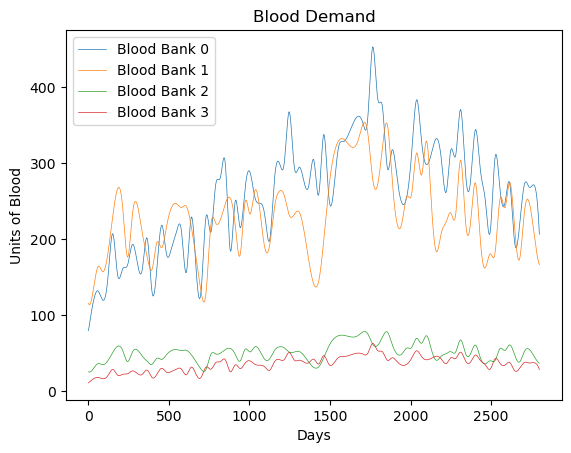

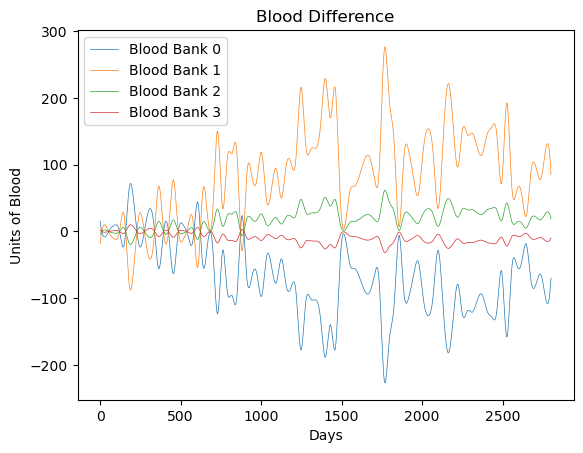

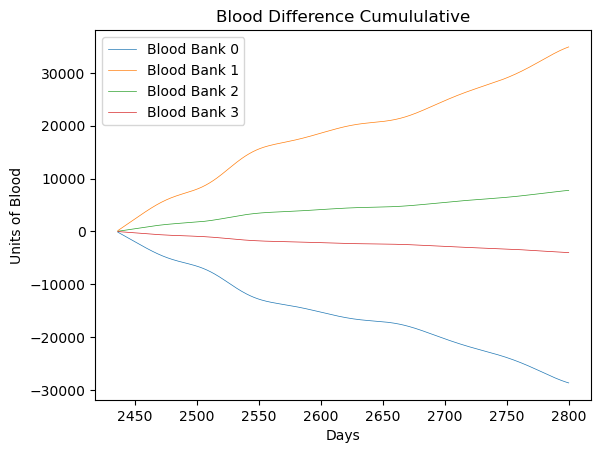

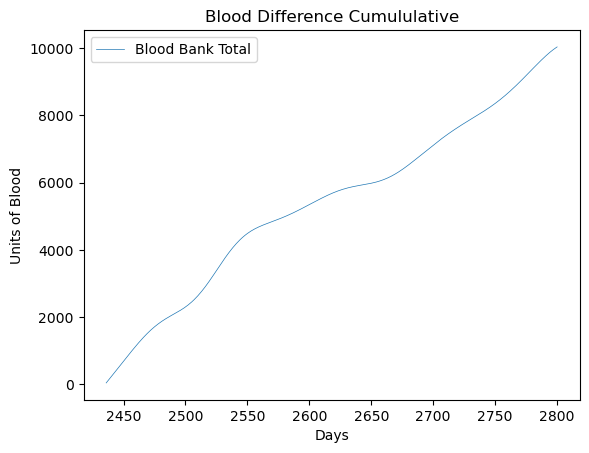

In [131]:
for n in range(N):
    plt.plot(times,supply[n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Supply')
    plt.legend()

plt.show()

for n in range(N):
    plt.plot(times,demand[n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Demand')
    plt.legend()

plt.show()

for n in range(N):
    plt.plot(times,supply[n]-demand[n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Difference')
    plt.legend()

plt.show()

for n in range(N):
    plt.plot(times[-365:],np.cumsum((supply[n]-demand[n])[-365:]),label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Difference Cumululative')
    plt.legend()

plt.show()

plt.plot(times[-365:],np.sum([np.cumsum((supply[n]-demand[n])[-365:]) for n in range(N)],axis=0),label='Blood Bank Total',linewidth=0.5)
plt.xlabel('Days')
plt.ylabel('Units of Blood')
plt.title('Blood Difference Cumululative')
plt.legend()

plt.show()

### Define Covariance Structure

In [32]:
def clip_eigenvalues(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues = np.where(np.real(eigenvalues) < 0, -eigenvalues, eigenvalues)
    eigenvalues = np.real(eigenvalues)
    return np.real(eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors))

def get_covariance_matrix(G,N,T,alpha=0.5,trans_decay=1.0,time_decay=1.0):
    transportation_cov = alpha*np.exp(-nx.adjacency_matrix(G).toarray()/trans_decay)
    time_cov = (1-alpha)*np.exp(-np.abs(np.subtract.outer(np.arange(T), np.arange(T)))/time_decay)
    
    cov = transportation_cov[:,np.newaxis,:,np.newaxis] + time_cov[np.newaxis,:,np.newaxis,:]
    cov = cov.reshape(N*T, N*T)
    cov = clip_eigenvalues(cov)
    return cov

### Generate Samples

In [33]:
mean = np.zeros(N*T)
cov = get_covariance_matrix(G,N,T,alpha=0.9,trans_decay=30.0,time_decay=10.0)
rv = stats.multivariate_normal(mean,cov,allow_singular=True)
samples = rv.rvs(size=2)

In [93]:
mean = np.zeros(N*T)
cov = np.load(directory + 'network_params/cov.npy')
rv = stats.multivariate_normal(mean,cov,allow_singular=True)
samples = rv.rvs(size=2)

In [140]:
scale = 1
supply_noise = scale*samples[0].reshape(N,T)
demand_noise = scale*samples[1].reshape(N,T)

for n in range(N):
    supply_noise[n] *= populations[n]
    demand_noise[n] *= populations[n]

total_supply = supply + supply_noise
total_demand = demand + demand_noise

data_network = np.array([total_supply,total_demand])
np.save(directory +'network_params/data_network',data_network)
np.save(directory + 'network_params/cov',cov)

### Plotting Results

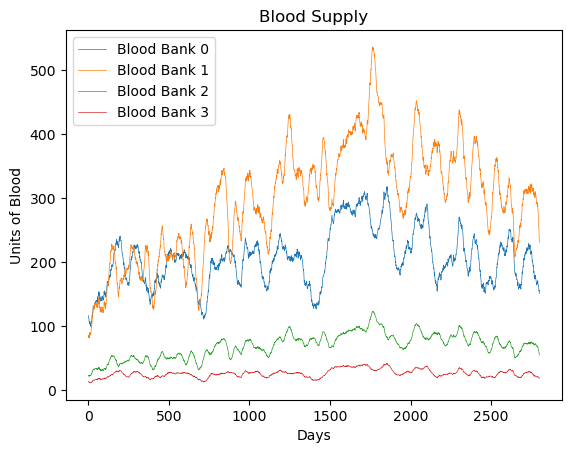

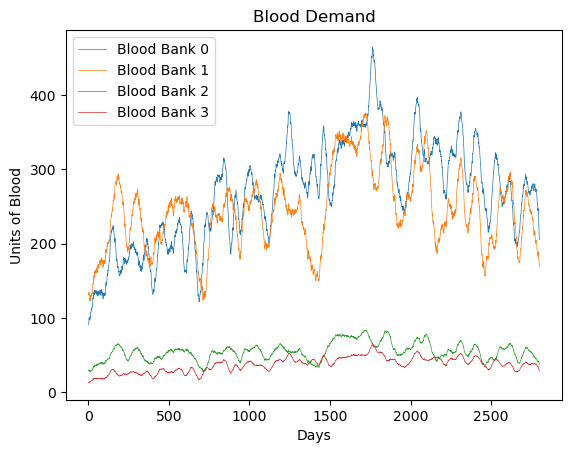

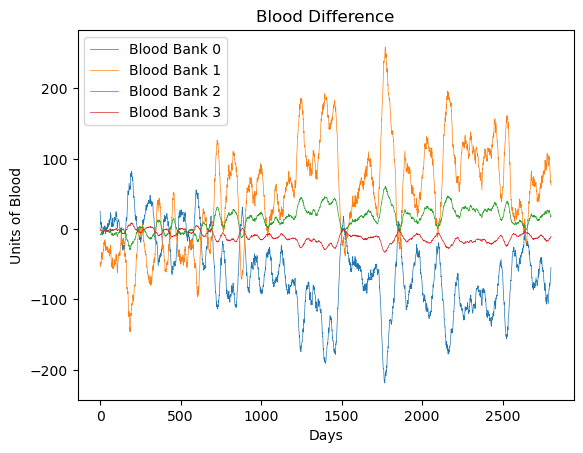

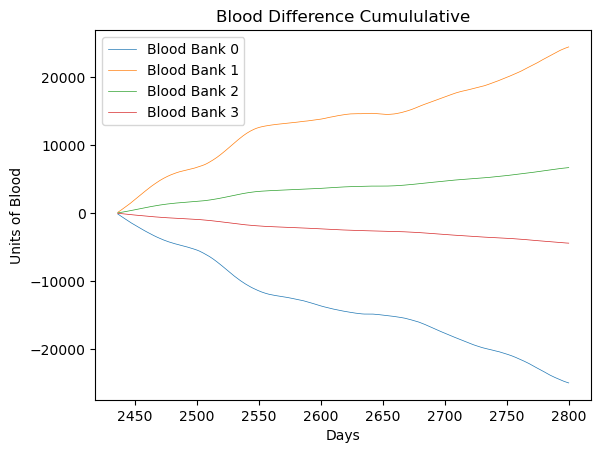

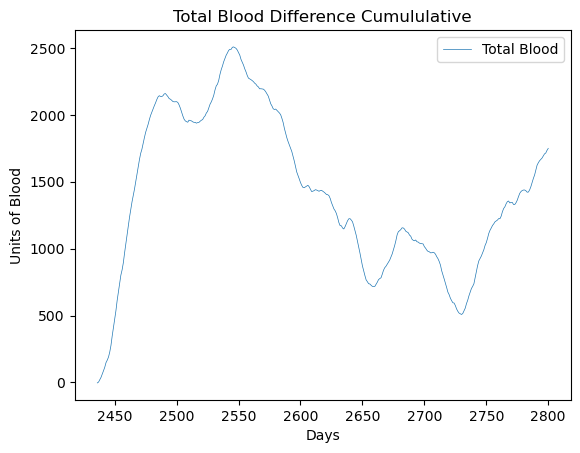

In [141]:
for n in range(len(data_network[0])):
    plt.plot(times,data_network[0,n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Supply')
    plt.legend()

plt.show()

for n in range(len(data_network[1])):
    plt.plot(times,data_network[1,n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Demand')
    plt.legend()

plt.show()

for n in range(len(data_network[1])):
    plt.plot(times,data_network[0,n]-data_network[1,n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Difference')
    plt.legend()

plt.show()

for n in range(len(data_network[1])):
    plt.plot(times[-365:],np.cumsum(data_network[0,n][-365:]-data_network[1,n][-365:]),label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Difference Cumululative')
    plt.legend()

plt.show()

plt.plot(times[-365:],np.sum([np.cumsum(data_network[0,n][-365:]-data_network[1,n][-365:]) for n in range(N)],axis=0),label='Total Blood',linewidth=0.5)
plt.xlabel('Days')
plt.ylabel('Units of Blood')
plt.title('Total Blood Difference Cumululative')
plt.legend()
plt.show()

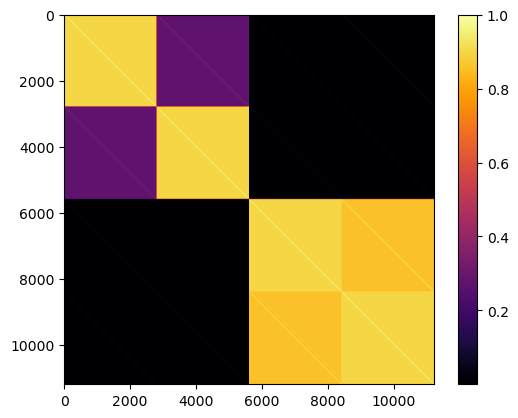

In [144]:
plt.imshow(np.real(cov),cmap='inferno')
plt.colorbar()
plt.savefig('cov.png')

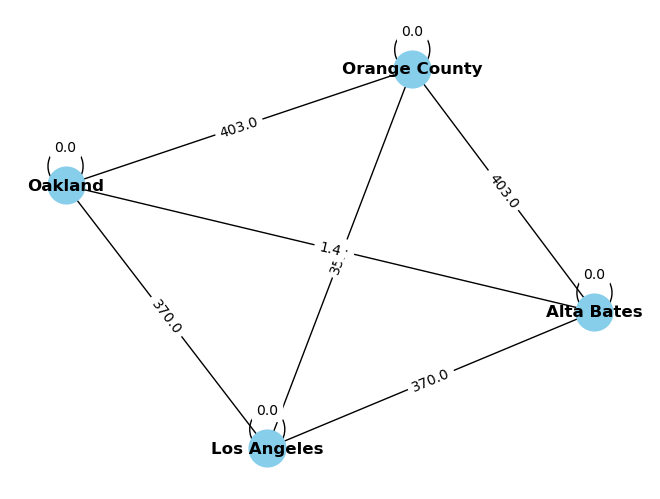

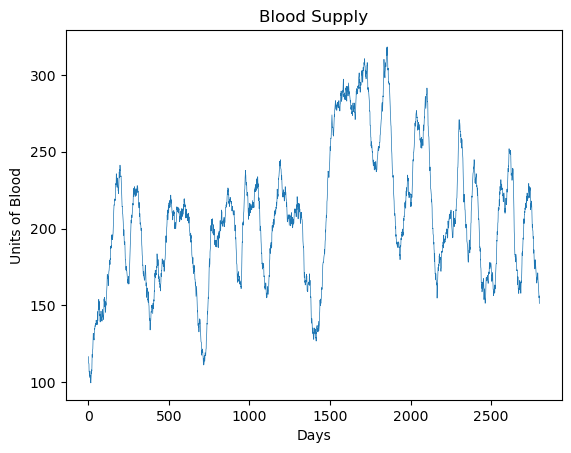

In [150]:
plt.plot(times,data_network[0,0],linewidth=0.5)
plt.xlabel('Days')
plt.ylabel('Units of Blood')
plt.title('Blood Supply')
plt.savefig('noisy_data.png', format='PNG')
plt.show()